<a href="https://colab.research.google.com/github/amay1212/Grokking-DL/blob/main/softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = "assignments/assignment1/"
assert FOLDERNAME is not None, "assignments/assignment1/"

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/assignments/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [ ]:
# a= np.random.randn(2, 2)
# b = np.random.randn(2, 2)
# matrix = np.zeros((2, 2))
# print(a)
# cols = b.shape[1]
# for i in range(len(a)):
#   for j in range(cols):
#     for k in range(len(a)):
#       matrix[i][j] += a[i][k] * b[k][j]

# print(matrix)

[[-1.18038651  0.44019946]
 [-0.01012519  0.6943514 ]]
[[1.47697743 0.86693853]
 [1.81255065 0.49892659]]


In [ ]:
t =np.array([1,2,3,4])
print(t, t.shape)
u = t[np.newaxis, :]
print(u.shape)

[1 2 3 4] (4,)
(1, 4)


In [ ]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
#print(W.shape, X_dev.shape)
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

(3073,)
loss: 2.428287
sanity check: 2.302585


In [ ]:
# (D, C) = > (3073, 10)
# (N, D) => (500, 3073)

# input * W (500, 3073) * (3073, 10) => (500, 10)

In [ ]:
-np.log(0.9)

0.10536051565782628

**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in*

Here we define that -log(0.1), 0.1 is probability, 0.1 is less confident, therefore we want our loss to increase. 0.1 probability means less confidence. We want this probability to be more. Lets try softmax with probability 0.8

and check we get more confidence and less loss.



In [ ]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

(3073,)
(3073,)
(3073,)
numerical: 1.751986 analytic: 1.751986, relative error: 4.281741e-08
(3073,)
(3073,)
numerical: 1.868844 analytic: 1.868844, relative error: 1.519148e-08
(3073,)
(3073,)
numerical: -1.329097 analytic: -1.329097, relative error: 1.499870e-08
(3073,)
(3073,)
numerical: 1.239129 analytic: 1.239129, relative error: 2.336070e-08
(3073,)
(3073,)
numerical: 0.227488 analytic: 0.227489, relative error: 1.365017e-07
(3073,)
(3073,)
numerical: 2.004713 analytic: 2.004713, relative error: 1.192370e-08
(3073,)
(3073,)
numerical: -3.130581 analytic: -3.130581, relative error: 1.661569e-09
(3073,)
(3073,)
numerical: 3.078224 analytic: 3.078224, relative error: 9.529765e-10
(3073,)
(3073,)
numerical: 0.707954 analytic: 0.707954, relative error: 7.258367e-08
(3073,)
(3073,)
numerical: -2.890083 analytic: -2.890083, relative error: 6.170929e-09
(3073,)
(3073,)
(3073,)
numerical: -0.619292 analytic: -0.619292, relative error: 1.944740e-08
(3073,)
(3073,)
numerical: -0.259512 anal

In [ ]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

(3073,)
naive loss: 2.428287e+00 computed in 0.062043s
vectorized loss: 2.428287e+00 computed in 0.017554s
Loss difference: 0.000000
Gradient difference: 0.000000


In [ ]:
import itertools
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

for lr, reg in itertools.product(learning_rates, regularization_strengths):
  print(lr, reg)

1e-07 25000.0
1e-07 50000.0
5e-07 25000.0
5e-07 50000.0


In [ ]:
X_train.shape

(49000, 3073)

In [ ]:
from cs231n.classifiers import Softmax

In [ ]:
help(Softmax)

Help on class Softmax in module cs231n.classifiers.linear_classifier:

class Softmax(LinearClassifier)
 |  A subclass that uses the Softmax + Cross-entropy loss function
 |  
 |  Method resolution order:
 |      Softmax
 |      LinearClassifier
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  loss(self, X_batch, y_batch, reg)
 |      Compute the loss function and its derivative.
 |      Subclasses will override this.
 |      
 |      Inputs:
 |      - X_batch: A numpy array of shape (N, D) containing a minibatch of N
 |        data points; each point has dimension D.
 |      - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
 |      - reg: (float) regularization strength.
 |      
 |      Returns: A tuple containing:
 |      - loss as a single float
 |      - gradient with respect to self.W; an array of the same shape as W
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from LinearClassifier:


In [ ]:
X_train.shape

(49000, 3073)

In [ ]:
X_dev.shape

(500, 3073)

In [ ]:
batch_indices = np.random.choice(X_dev.shape[0], size=200, replace=True)

In [ ]:
X_dev[batch_indices]

array([[ -51.64189796,  -49.98173469,  -78.47391837, ...,  -16.86195918,
         -24.39957143,    1.        ],
       [-123.64189796, -129.98173469, -118.47391837, ...,  -84.86195918,
         -93.39957143,    1.        ],
       [  32.35810204,   78.01826531,  100.52608163, ...,  -22.86195918,
         -47.39957143,    1.        ],
       ...,
       [  97.35810204,   96.01826531,  110.52608163, ...,   82.13804082,
          90.60042857,    1.        ],
       [ -21.64189796,  -18.98173469,   15.52608163, ...,  -13.86195918,
         -38.39957143,    1.        ],
       [ -93.64189796,  -56.98173469,   20.52608163, ...,  -57.86195918,
          42.60042857,    1.        ]])

In [ ]:
num_classes = (
            np.max(y_dev) + 1
        )

In [ ]:
num_classes

10

In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################


learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

num_folds = 5
X_train_folds=np.array_split(X_train, num_folds)
y_train_folds=np.array_split(y_train, num_folds)
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
cv_fold=list(range(num_folds))

# Import useful libraries
import sys

# Binary variable to print extra info within the loop
Verbose=False
label_folds = np.array_split(y_train, 5)
results = {}
for lr, reg in itertools.product(learning_rates, regularization_strengths):
    softmax=Softmax()
    softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1000)
    y_train_pred=softmax.predict(X_train)
    y_val_pred=softmax.predict(X_val)
    training_accuracy=np.mean(y_train_pred==y_train)
    validation_accuracy=np.mean(y_val_pred==y_val)
    if validation_accuracy > best_val:
      best_val = validation_accuracy
      best_softmax = softmax

    results[lr, reg] = (training_accuracy, validation_accuracy)

# #print(results)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):

    train_accuracy, val_accuracy = results[(lr, reg)]


    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.340673 val accuracy: 0.356000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.323776 val accuracy: 0.340000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.351837 val accuracy: 0.359000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.327245 val accuracy: 0.342000
best validation accuracy achieved during cross-validation: 0.359000


In [ ]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.357000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



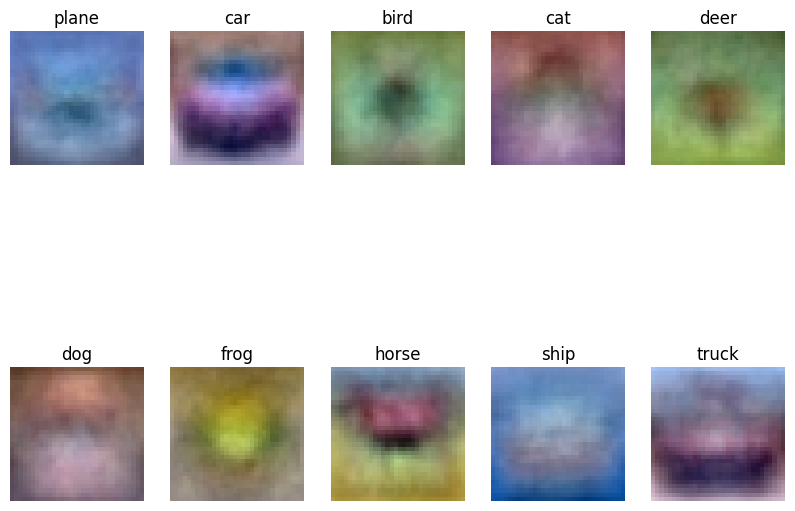

In [ ]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])